# Network Clustering 

In this example, we show how pypsa can deal with spatial clustering of networks. 

In [1]:
import pypsa
import re
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pandas as pd
from pypsa.networkclustering import get_clustering_from_busmap, busmap_by_kmeans

In [2]:
n = pypsa.examples.scigrid_de()
n.lines["type"] = np.nan # delete the 'type' specifications to make this example easier

Importing PyPSA from older version of PyPSA than current version.
Please read the release notes at https://pypsa.org/doc/release_notes.html
carefully to prepare your network for import. 
Currently used PyPSA version [0, 18, 1], imported network file PyPSA version [0, 17, 1].

INFO:pypsa.io:Imported network scigrid-de.nc has buses, generators, lines, loads, storage_units, transformers


The important information that pypsa needs for spatial clustering is in the `busmap`. It contains the mapping of which buses should be grouped together, similar to the groupby groups as we know it from pandas.

You can either calculate a `busmap` from the provided clustering algorithms or you can create/use your own busmap.

## Cluster by custom busmap

Let's start with creating our own. 
In the following, we group all buses together which belong to the same operator. Buses which do not have a specific operator just stay on its own.

In [3]:
groups = n.buses.operator.apply(lambda x: re.split(" |,|;", x)[0])
busmap = groups.where(groups != "", n.buses.index)

Now we cluster the network based on the busmap.

In [4]:
C = get_clustering_from_busmap(n, busmap)

`C` is a Clustering object which contains all important information.
Among others, the new network is now stored in that Clustering object.

In [5]:
nc = C.network

We have a look at the original and the clustered topology

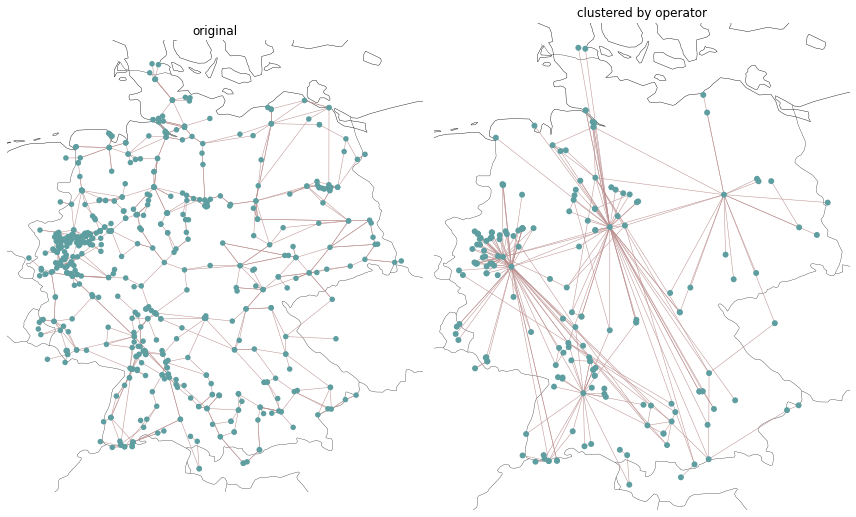

In [13]:
fig, (ax, ax1) = plt.subplots(1, 2, subplot_kw={"projection": ccrs.EqualEarth()}, figsize=(12,12))
plot_kwrgs = dict(bus_sizes=1e-3, line_widths=0.5)
n.plot(ax=ax, title="original", **plot_kwrgs)
nc.plot(ax=ax1, title="clustered by operator", **plot_kwrgs)
fig.tight_layout()

Looks a bit messy as over 120 buses do not have assigned operators.

## Clustering by busmap created from K-means

Let's now make a clustering based on the kmeans algorithm.
Therefore we calculate the `busmap` from a non-weighted kmeans clustering.

In [15]:
weighting = pd.Series(1, n.buses.index)
busmap2 = busmap_by_kmeans(n, bus_weightings=weighting, n_clusters=50)

/home/fabian/.miniconda3/lib/python3.8/site-packages/sklearn/base.py:434: UserWarning:

X has feature names, but KMeans was fitted without feature names



We use this new kmeans-based `busmap` to create a new clustered method.

In [16]:
C2 = get_clustering_from_busmap(n, busmap2)
nc2 = C2.network

Again, let's plot the networks to compare:

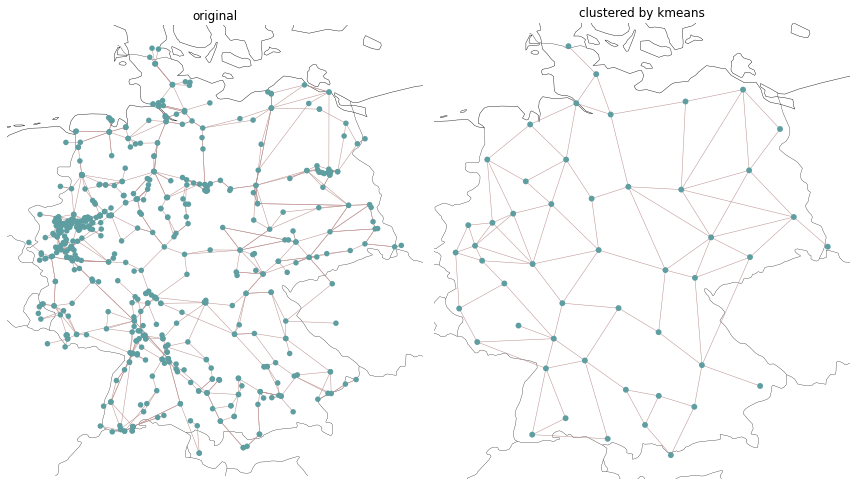

In [18]:
fig, (ax, ax1) = plt.subplots(1, 2, subplot_kw={"projection": ccrs.EqualEarth()}, figsize=(12,12))
plot_kwrgs = dict(bus_sizes=1e-3, line_widths=0.5)
n.plot(ax=ax, title="original", **plot_kwrgs)
nc2.plot(ax=ax1, title="clustered by kmeans", **plot_kwrgs)
fig.tight_layout()

There are other clustering algorithms in the pipeline of pypsa as the hierarchical
clustering which performs better than the kmeans. Also the `get_clustering_from_busmap` function supports various arguments on how components in the network should be aggregated. 